# Importing our libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
!pip install neattext
import neattext.functions as nfx
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
import pickle
from sklearn.preprocessing import LabelEncoder
import keras
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 KB 2.8 MB/s eta 0:00:00


# Read dataset

In [ ]:
data = pd.read_csv('Suicide_Detection.csv')

# Splitting data to train and test

In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

# Exploratory data analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   999 non-null    int64 
 1   description  999 non-null    object
 2   class        999 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


# Plot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


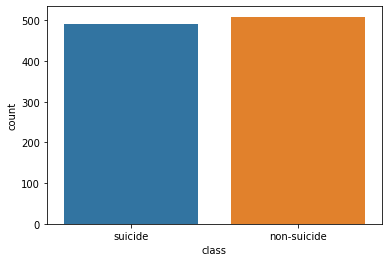

In [ ]:
sn.countplot(data['class'])
plt.show()

In [ ]:
data['class'].value_counts()

non-suicide    509
suicide        490
Name: class, dtype: int64

In [ ]:
data['class'].value_counts().index.values

array(['non-suicide', 'suicide'], dtype=object)

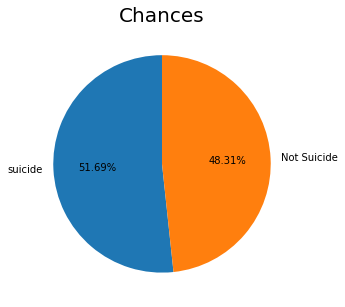

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(train_data['class'].value_counts(),startangle=90, autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('Chances',fontdict={'size':20})
plt.show()

# Data cleaning and preprocessing

Stopwords and special characters removal

In [ ]:
def clean_text(description):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(description):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.description)
cleaned_test_text,test_text_length=clean_text(test_data.description)
# cleaned_train_text

100%|██████████| 200/200 [00:00<00:00, 9002.58it/s]


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


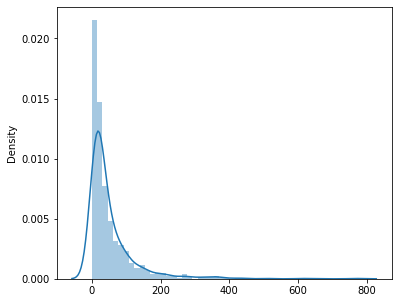

In [ ]:
plt.figure(figsize=(6,5))
sn.distplot(train_text_length)
plt.show()

# tokenizing the text

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)
tokenizer

# Finding word frequency

In [ ]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
word_freq

,word,count
77,im,1026
23,dont,654
9,like,588
47,want,488
100,know,425
...,...,...
4645,gaslighting,1
4644,deceit,1
4643,extensive,1
4642,objects,1


# WordCloud

(-0.5, 399.5, 199.5, -0.5)

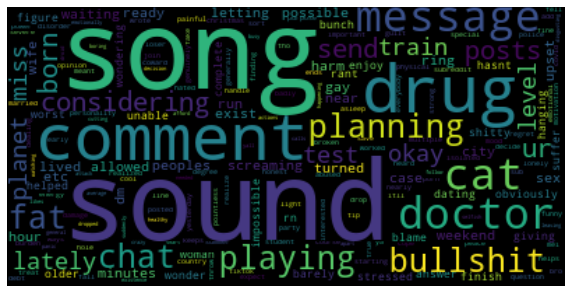

In [ ]:
from wordcloud import WordCloud
feature_names=word_freq['word'].values
wc=WordCloud(max_words=200)
wc.generate(' '.join(word for word in feature_names[500:1000] ))
# plt.figure(figsize=(20,15))

# plt.show()
plt.figure(figsize=(10, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

# Visualization

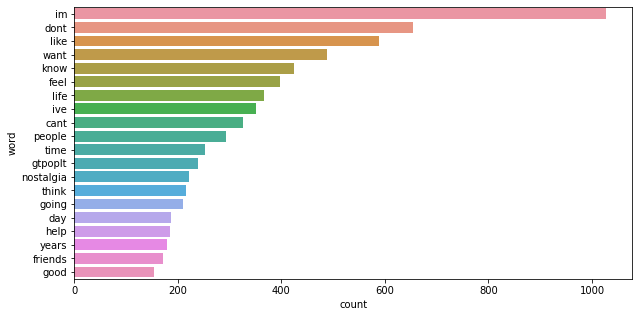

In [ ]:
# train_incidents = 
# cleaned_train_text["description"].apply(lambda x: word_tokenize(x))
description_most_freq_words = pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
description_most_freq_words.head(20)
sd_freq_plot = description_most_freq_words.head(20)
plt.figure(figsize=(10,5))
sn.barplot(x='count',y='word',data=sd_freq_plot)
plt.show()

# Bigrams

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                    frequency
000 000                    10
000 billionday              1
000 millionday              1
000 quadrillionday          1
000 trillionday             1
...                       ...
zone repost                 1
zoom classes                1
zoom past                   1
zoom shit                   1
zooms dmd                   1

[34258 rows x 1 columns]


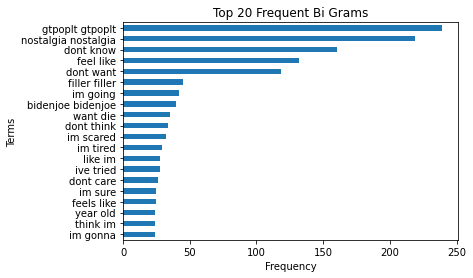

In [ ]:
# bigrams = TextBlob(pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False).ngrams(2)
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(cleaned_train_text)
frequencies = sum(sparse_matrix).toarray()[0]
bi_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print(bi_grams_df)
bi_grams_df.sort_values(by = "frequency",ascending=False).head(20)
# plt.style.use("sn")

plt.xlabel("Frequency",)
plt.ylabel("Terms")
top20_bigrams = bi_grams_df["frequency"].sort_values(ascending = False).head(20)

top20_bigrams.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Bi Grams")
sn.set_theme()
plt.show()

In [ ]:
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(cleaned_train_text)
frequencies = sum(sparse_matrix).toarray()[0]
bi_grams_issue_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

bi_grams_issue_df[bi_grams_issue_df.index.str.contains("kill")].sort_values(by = "frequency",ascending=False).head(10)
print(bi_grams_issue_df)

                    frequency
000 000                    10
000 billionday              1
000 millionday              1
000 quadrillionday          1
000 trillionday             1
...                       ...
zone repost                 1
zoom classes                1
zoom past                   1
zoom shit                   1
zooms dmd                   1

[34258 rows x 1 columns]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Trigrams

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


                        frequency
000 000 000                     6
000 000 billionday              1
000 000 millionday              1
000 000 quadrillionday          1
000 000 trillionday             1
...                           ...
zodiac signoh canceri           1
zoom classes spread             1
zoom past faster                1
zoom shit real                  1
zooms dmd instagram             1

[38624 rows x 1 columns]


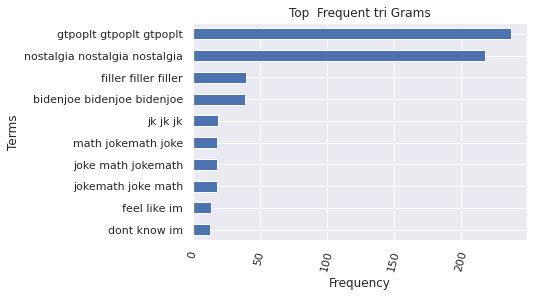

In [ ]:
word_vectorizer = CountVectorizer(ngram_range=(3,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(cleaned_train_text)
#sparse_matrix = word_vectorizer.fit_transform(train_incidents["short_description_tokens"])
frequencies = sum(sparse_matrix).toarray()[0]
tri_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
tri_grams_df.sort_values(by = "frequency",ascending=False).head(20)
print(tri_grams_df)
### Analyzing top 20 frequent Tri Gram words

# plt.style.use("ggplot")
# plt.xlabel("Terms",)
# plt.ylabel("Frequency")
trigrams_short_description = tri_grams_df["frequency"].sort_values(ascending = False)
# top20_trigrams = tri_grams_df["frequency"].sort_values(ascending = False).head(20)

# top5_trigrams_plot =  top20_trigrams.head(10).sort_values(ascending = False).plot(kind="bar",title = "Top 5 Frequent Tri Grams")
# top5_trigrams_plot
plt.xticks(rotation=75)
plt.xlabel("Frequency",)
plt.ylabel("Terms")
top20_trigrams = tri_grams_df["frequency"].sort_values(ascending = False).head(20)

top20_trigrams.head(10).sort_values(ascending = True).plot(kind="barh",title = "Top  Frequent tri Grams")
sn.set_theme()
plt.show()

# Encoding our text

In [ ]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)
# train_text_pad

test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

# Glove embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 
!unzip -q glove.6B.zip

--2023-02-10 00:22:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-10 00:22:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-10 00:22:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  Suicide_Detection.csv
glove.6B.200d.txt  glove.6B.50d.txt   sample_data
/content


In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

# Model building

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [ ]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
4/4 [==============================] - 4s 301ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6885 - val_accuracy: 0.5400 - lr: 0.1000
Epoch 2/20
4/4 [==============================] - 0s 91ms/step - loss: 0.6904 - accuracy: 0.5106 - val_loss: 0.6827 - val_accuracy: 0.5450 - lr: 0.1000
Epoch 3/20
4/4 [==============================] - 0s 100ms/step - loss: 0.6868 - accuracy: 0.5031 - val_loss: 0.6799 - val_accuracy: 0.5450 - lr: 0.1000
Epoch 4/20
4/4 [==============================] - 1s 159ms/step - loss: 0.6836 - accuracy: 0.5219 - val_loss: 0.6769 - val_accuracy: 0.5650 - lr: 0.1000
Epoch 5/20
4/4 [==============================] - 1s 150ms/step - loss: 0.6802 - accuracy: 0.5582 - val_loss: 0.6732 - val_accuracy: 0.6150 - lr: 0.1000
Epoch 6/20
4/4 [==============================] - 1s 179ms/step - loss: 0.6764 - accuracy: 0.5995 - val_loss: 0.6678 - val_accuracy: 0.5900 - lr: 0.1000
Epoch 7/20
4/4 [==============================] - 1s 164ms/step - loss: 0.6725 - ac

# Evaluating Our Model

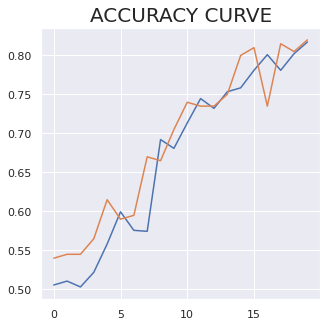

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

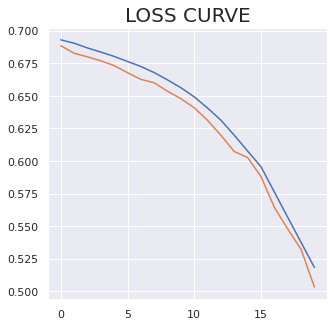

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

# Saving the model

In [ ]:
model.save("/working/model")

# Creating function for prediction

In [ ]:
def detectSuicide(description):
    cleaned_text, length = clean_text(description)
    tokens = tokenizer.texts_to_sequences(cleaned_text)
    paded = pad_sequences(tokens,maxlen=50)
    if model.predict([paded]) >=0.33:
        print("contains suicidal thoughts")
    else:
        print("Doesn't contains suicidal thoughts")

In [ ]:
detectSuicide(["feel happy"])

100%|██████████| 1/1 [00:00<00:00, 1921.35it/s]


1/1 [==============================] - 0s 144ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I am happy as my presentations were good"])

100%|██████████| 1/1 [00:00<00:00, 4934.48it/s]

1/1 [==============================] - 0s 40ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I want to go to paris"])

100%|██████████| 1/1 [00:00<00:00, 4750.06it/s]

1/1 [==============================] - 0s 30ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["My exams went good"])

100%|██████████| 1/1 [00:00<00:00, 4888.47it/s]

1/1 [==============================] - 0s 28ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I feel sad I want to die"])

100%|██████████| 1/1 [00:00<00:00, 5924.16it/s]

1/1 [==============================] - 0s 31ms/step
contains suicidal thoughts


In [ ]:
detectSuicide(["I need sleep"])

100%|██████████| 1/1 [00:00<00:00, 5171.77it/s]

1/1 [==============================] - 0s 27ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["Everyone is cheerful as we are having our last presentation"])

100%|██████████| 1/1 [00:00<00:00, 5683.34it/s]

1/1 [==============================] - 0s 40ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["Everyone happy"])

100%|██████████| 1/1 [00:00<00:00, 1841.22it/s]


1/1 [==============================] - 0s 62ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["My grandfather is hospitalized so I am sad"])

100%|██████████| 1/1 [00:00<00:00, 4396.55it/s]

1/1 [==============================] - 0s 37ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I want to cry"])

100%|██████████| 1/1 [00:00<00:00, 3457.79it/s]

1/1 [==============================] - 0s 44ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I need food"])

100%|██████████| 1/1 [00:00<00:00, 4185.93it/s]

1/1 [==============================] - 0s 35ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I want to die"])

100%|██████████| 1/1 [00:00<00:00, 4848.91it/s]

1/1 [==============================] - 0s 31ms/step
contains suicidal thoughts


In [ ]:
detectSuicide(["I am depressed"])

100%|██████████| 1/1 [00:00<00:00, 3483.64it/s]

1/1 [==============================] - 0s 50ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I love you"])

100%|██████████| 1/1 [00:00<00:00, 3486.54it/s]


1/1 [==============================] - 0s 44ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["my phone is missing"])

100%|██████████| 1/1 [00:00<00:00, 598.67it/s]


1/1 [==============================] - 0s 120ms/step
Doesn't contains suicidal thoughts


In [ ]:
detectSuicide(["I am single"])

100%|██████████| 1/1 [00:00<00:00, 5053.38it/s]

1/1 [==============================] - 0s 32ms/step
Doesn't contains suicidal thoughts
